In [1]:
!pip install seaborn
!pip install matplotlib

     |████████████████████████████████| 215 kB 6.8 MB/s eta 0:00:01


In [2]:
import os
import glob
import re
import pandas as pd
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor
from more_itertools import chunked

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
%pwd
%cd /workspace/oid2yolo

/workspace/oid2yolo


In [73]:
oid_path = "/workspace/open_images_dataset_v6/subset_600"

In [7]:
oid_class_csv = oid_path + '/class-descriptions-boxable.csv'

class_names = ['Human face', 'Vehicle registration plate']
df_all_classes = pd.read_csv(oid_class_csv, names=['LabelName', 'ClassName'])
df_classes = df_all_classes[df_all_classes['ClassName'].isin(class_names)].copy()
df_classes['order'] = df_classes['ClassName'].apply(lambda x: class_names.index(x))
df_classes.sort_values('order', inplace=True)
df_classes.reset_index(drop=True, inplace=True)
df_classes.drop(columns='order', inplace=True)

In [8]:
org_train_csv = oid_path + '/oidv6-train-annotations-bbox.csv'
org_val_csv = oid_path + '/validation-annotations-bbox.csv'
org_test_csv = oid_path + '/test-annotations-bbox.csv'

In [218]:
class_filter_all =  [
      ["Vehicle registration plate"],
      ["Human face", "Truck"],
      ["Human face", "Bus"],
      ["Human face", "Van"],
      ["Human face", "Ambulance"],
      ["Human face", "Limousine"],
      ["Human face", "Taxi"],
      ["Human face", "Bicycle"],
      ["Human face", "Bicycle wheel"],
      ["Human face", "Bicycle helmet"],
      ["Human face", "Motorcycle"],
      ["Human face", "Traffic light"],
      ["Human face", "Traffic sign"],
      ["Human face", "Stop sign"],
      ["Human face", "Parking meter"],
      ["Human face", "Cart"],
      ["Human face", "Street light"],
      ["Human face", "Skateboard"],
      ["Human face", "Wheelchair"],
      ["Human face", "Billboard"],
      ["Human face", "Fire hydrant"],
      ["Human face", "Office building"],
      ["Human face", "Fountain"],
      ["Human face", "Stretcher"],
      ["Human face", "Roller skates"],
      ["Human face", "Sun hat"],
      ["Human face", "Helmet"],
      ["Human face", "Sunglasses"],
      ["Human face", "Mobile phone"],
      ["Human face", "Briefcase"],
      ["Human face", "Bench"]
]

In [219]:
def split_last_df_image(df):
    df_image = df.groupby("ImageID")
    last_image_id = df.tail(1)["ImageID"]
    last_group = df_image.get_group(*last_image_id)
    last_group_len = len(last_group)
    if last_group_len < len(df):
        df.drop(df.tail(last_group_len).index, inplace=True)
    df_rest = last_group
    return df, df_rest

In [220]:
def flatten_list(l):
    for el in l:
        if isinstance(el, list):
            yield from flatten_list(el)
        else:
            yield el

In [221]:
def image_filter_func(df, class_filter_list):
    for class_filter in class_filter_list:
        if set(class_filter).issubset(list(df["ClassName"])):
            return df[df['ClassName'].isin(flatten_list(class_filter_list))]
    return None

In [222]:
def apply_image_filter(df, class_filter_list, df_class):
    df['ClassName'] = df['LabelName'].agg(lambda x: df_class.loc[df_class[df_class['LabelName'] == x].index[0], "ClassName"])
    return df.groupby("ImageID", as_index=False).apply(image_filter_func, class_filter_list=class_filter_list)

In [223]:
def read_csv_chunk(csv_file, df_classes):
    futures = []
    with ProcessPoolExecutor(max_workers=os.cpu_count()) as executor:
        use_columns = ["ImageID", "LabelName"]
        df_rest = None
        for index, df_bbox in enumerate(pd.read_csv(csv_file, header=0, usecols=use_columns, chunksize=10000)):
            df, df_last = split_last_df_image(df_bbox)
            if df_rest is not None:
                df = pd.concat([df_rest, df])
            df_rest = df_last
            future = executor.submit(apply_image_filter, df, class_filter_all, df_classes)
            futures.append(future)
    concurrent.futures.wait(futures, timeout=None)
    df_list = [future.result() for future in concurrent.futures.as_completed(futures)]
    df_csv_all = pd.DataFrame(data=None)
    for df in df_list:
        df_csv_all = pd.concat([df_csv_all, df])
    return df_csv_all

In [224]:
df_org_train = read_csv_chunk(org_train_csv, df_all_classes)
df_org_val = read_csv_chunk(org_val_csv, df_all_classes)
df_org_test = read_csv_chunk(org_test_csv, df_all_classes)

In [225]:
display(df_org_train["ClassName"].value_counts())
display(df_org_train["ClassName"].value_counts(normalize=True))
print(f"the number of images: {len(df_org_train.index.unique())}")

Human face                    48951
Sunglasses                    15256
Vehicle registration plate     7852
Helmet                         4538
Sun hat                        3788
Bicycle wheel                  2300
Bicycle                        1826
Bicycle helmet                 1226
Mobile phone                    939
Billboard                       875
Street light                    773
Office building                 753
Bus                             747
Roller skates                   656
Van                             583
Motorcycle                      507
Truck                           433
Traffic light                   253
Traffic sign                    211
Bench                           202
Taxi                            188
Wheelchair                      113
Cart                             85
Fountain                         78
Skateboard                       70
Limousine                        15
Stop sign                        10
Stretcher                   

Human face                    0.524916
Sunglasses                    0.163594
Vehicle registration plate    0.084199
Helmet                        0.048662
Sun hat                       0.040620
Bicycle wheel                 0.024664
Bicycle                       0.019581
Bicycle helmet                0.013147
Mobile phone                  0.010069
Billboard                     0.009383
Street light                  0.008289
Office building               0.008075
Bus                           0.008010
Roller skates                 0.007034
Van                           0.006252
Motorcycle                    0.005437
Truck                         0.004643
Traffic light                 0.002713
Traffic sign                  0.002263
Bench                         0.002166
Taxi                          0.002016
Wheelchair                    0.001212
Cart                          0.000911
Fountain                      0.000836
Skateboard                    0.000751
Limousine                

the number of images: 93255


In [226]:
display(df_org_val["ClassName"].value_counts())
display(df_org_val["ClassName"].value_counts(normalize=True))
print(f"the number of images: {len(df_org_val.index.unique())}")

Vehicle registration plate    987
Human face                    428
Helmet                        131
Sunglasses                    106
Bicycle wheel                  59
Taxi                           45
Sun hat                        42
Van                            30
Bicycle helmet                 28
Bicycle                        27
Bus                            17
Truck                          16
Motorcycle                     15
Wheelchair                     15
Roller skates                  14
Mobile phone                   11
Traffic light                  10
Office building                 7
Skateboard                      5
Billboard                       5
Cart                            5
Street light                    5
Limousine                       3
Traffic sign                    3
Parking meter                   1
Ambulance                       1
Name: ClassName, dtype: int64

Vehicle registration plate    0.489583
Human face                    0.212302
Helmet                        0.064980
Sunglasses                    0.052579
Bicycle wheel                 0.029266
Taxi                          0.022321
Sun hat                       0.020833
Van                           0.014881
Bicycle helmet                0.013889
Bicycle                       0.013393
Bus                           0.008433
Truck                         0.007937
Motorcycle                    0.007440
Wheelchair                    0.007440
Roller skates                 0.006944
Mobile phone                  0.005456
Traffic light                 0.004960
Office building               0.003472
Skateboard                    0.002480
Billboard                     0.002480
Cart                          0.002480
Street light                  0.002480
Limousine                     0.001488
Traffic sign                  0.001488
Parking meter                 0.000496
Ambulance                

the number of images: 2016


In [227]:
display(df_org_test["ClassName"].value_counts())
display(df_org_test["ClassName"].value_counts(normalize=True))
print(f"the number of images: {len(df_org_test.index.unique())}")

Vehicle registration plate    2843
Human face                    1319
Sunglasses                     316
Helmet                         283
Sun hat                        167
Bicycle wheel                  118
Van                             93
Roller skates                   91
Bicycle                         76
Bicycle helmet                  72
Bus                             68
Truck                           68
Motorcycle                      24
Street light                    23
Taxi                            22
Wheelchair                      20
Office building                 19
Traffic light                   17
Mobile phone                    16
Cart                            15
Traffic sign                    14
Skateboard                      11
Ambulance                        9
Billboard                        8
Limousine                        4
Name: ClassName, dtype: int64

Vehicle registration plate    0.497376
Human face                    0.230756
Sunglasses                    0.055283
Helmet                        0.049510
Sun hat                       0.029216
Bicycle wheel                 0.020644
Van                           0.016270
Roller skates                 0.015920
Bicycle                       0.013296
Bicycle helmet                0.012596
Bus                           0.011896
Truck                         0.011896
Motorcycle                    0.004199
Street light                  0.004024
Taxi                          0.003849
Wheelchair                    0.003499
Office building               0.003324
Traffic light                 0.002974
Mobile phone                  0.002799
Cart                          0.002624
Traffic sign                  0.002449
Skateboard                    0.001924
Ambulance                     0.001575
Billboard                     0.001400
Limousine                     0.000700
Name: ClassName, dtype: f

the number of images: 5716


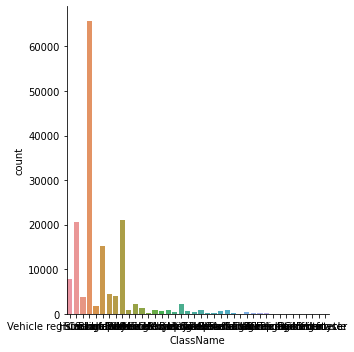

In [20]:
sns.catplot(data=df_org_train, x="ClassName", kind="count")
plt.show()

In [21]:
need_columns = ["ImageID", "LabelName"]
df_org_train = pd.read_csv(org_train_csv, header=0, usecols=need_columns)
df_org_train['ClassName'] = df_org_train['LabelName'].agg(
    lambda x: df_all_classes.loc[df_all_classes[df_all_classes['LabelName'] == x].index[0], "ClassName"])

KeyboardInterrupt: 

In [ ]:
display(df_org_test["ClassName"].value_counts())
display(df_org_test["ClassName"].value_counts(normalize=True))
print(f"the number of images: {len(df_org_test.index.unique())}")

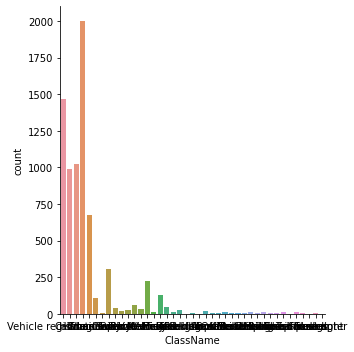

In [44]:
sns.catplot(data=df, x="ClassName", kind="count")
plt.show()

In [ ]:
need_columns = ["ImageID", "LabelName"]
df_org_train = pd.read_csv(org_train_csv, header=0, usecols=need_columns)
df_org_train['ClassName'] = df_org_train['LabelName'].agg(
    lambda x: df_all_classes.loc[df_all_classes[df_all_classes['LabelName'] == x].index[0], "ClassName"])

In [ ]:
display(df_oid_all["ClassName"].value_counts())
display(df_oid_all["ClassName"].value_counts(normalize=True))
print(f"the number of images: {len(df_oid_all.index.unique())}")

# analyzing after shrink

In [356]:
oid_path = "/workspace/open_images_dataset_v6/subset_600"

In [357]:
oid_class_csv = oid_path + '/class-descriptions-boxable.csv'

class_names = ['Human face', 'Vehicle registration plate']
df_all_classes = pd.read_csv(oid_class_csv, names=['LabelName', 'ClassName'])
df_classes = df_all_classes[df_all_classes['ClassName'].isin(class_names)].copy()
df_classes['order'] = df_classes['ClassName'].apply(lambda x: class_names.index(x))
df_classes.sort_values('order', inplace=True)
df_classes.reset_index(drop=True, inplace=True)
df_classes.drop(columns='order', inplace=True)

In [358]:
oid_train_csv = oid_path + '/oidv6-train-annotations-bbox_selected.csv'
oid_val_csv = oid_path + '/validation-annotations-bbox_selected.csv'
oid_test_csv = oid_path + '/test-annotations-bbox_selected.csv'

In [359]:
def set_dataset_type(df, dataset_type, df_class):
    df['set'] = dataset_type
    df = df.set_index("ImageID")
    df['ClassName'] = df['LabelName'].agg(lambda x: df_class.loc[df_class[df_class['LabelName'] == x].index[0], "ClassName"])
    return df

In [360]:
def read_csv_chunk(csv_file, dataset_type, df_class):
    futures = []
    with ProcessPoolExecutor(max_workers=os.cpu_count()) as executor:
        use_columns = ["ImageID", "LabelName"]
        df_rest = None
        for index, df_bbox in enumerate(pd.read_csv(csv_file, header=0, usecols=use_columns, chunksize=10000)):
            df, df_last = split_last_df_image(df_bbox)
            if df_rest is not None:
                df = pd.concat([df_rest, df])
            df_rest = df_last
            future = executor.submit(set_dataset_type, df, dataset_type, df_class)
            futures.append(future)
    concurrent.futures.wait(futures, timeout=None)
    df_list = [future.result() for future in concurrent.futures.as_completed(futures)]
    df_csv_all = pd.DataFrame(data=None)
    for df in df_list:
        df_csv_all = pd.concat([df_csv_all, df])
    return df_csv_all

In [361]:
df_oid_train = read_csv_chunk(oid_train_csv, 'train', df_classes)

In [362]:
df_oid_val = read_csv_chunk(oid_val_csv, 'val', df_classes)
df_oid_test = read_csv_chunk(oid_test_csv, 'test', df_classes)

In [363]:
df_oid_all = pd.concat([df_oid_train, df_oid_val, df_oid_test])

In [364]:
df_oid_all.head()

,LabelName,set,ClassName
ImageID,,,
cc4f0f9b6fe798d7,/m/0dzct,train,Human face
cc4f0f9b6fe798d7,/m/0dzct,train,Human face
cc4f0f9b6fe798d7,/m/0dzct,train,Human face
cc4f0f9b6fe798d7,/m/0dzct,train,Human face
cc4f0f9b6fe798d7,/m/0dzct,train,Human face


In [365]:
class_order = ["Human face", "Vehicle registration plate"]

In [366]:
display(df_oid_all["ClassName"].value_counts())
display(df_oid_all["ClassName"].value_counts(normalize=True))
print(f"the number of images: {len(df_oid_all.index.unique())}")

Human face                    39745
Vehicle registration plate    11681
Name: ClassName, dtype: int64

Human face                    0.772858
Vehicle registration plate    0.227142
Name: ClassName, dtype: float64

the number of images: 23358


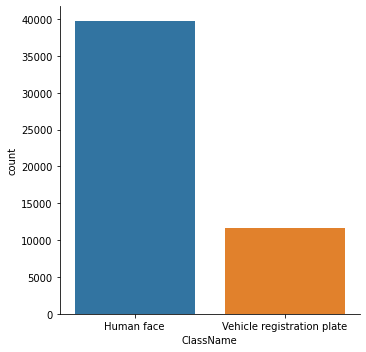

In [367]:
sns.catplot(data=df_oid_all, x="ClassName", kind="count", order=class_order)
plt.show()

Human face                    31308
Vehicle registration plate     7851
Name: ClassName, dtype: int64

Human face                    0.79951
Vehicle registration plate    0.20049
Name: ClassName, dtype: float64

the number of images: 17090


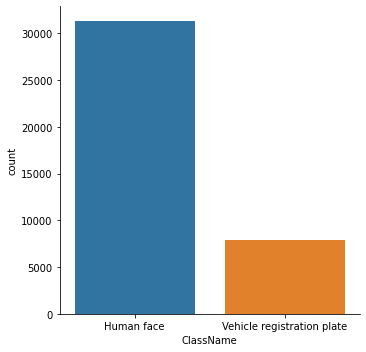

In [368]:
df_oid_train = df_oid_all[df_oid_all["set"] == "train"]
display(df_oid_train["ClassName"].value_counts())
display(df_oid_train["ClassName"].value_counts(normalize=True))
print(f"the number of images: {len(df_oid_train.index.unique())}")
sns.catplot(data=df_oid_train, x="ClassName", kind="count", order=class_order)
plt.show()

Vehicle registration plate    987
Human face                    548
Name: ClassName, dtype: int64

Vehicle registration plate    0.642997
Human face                    0.357003
Name: ClassName, dtype: float64

the number of images: 986


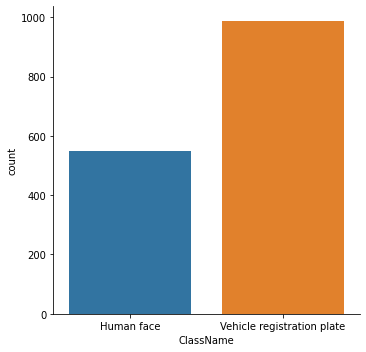

In [369]:
df_oid_val = df_oid_all[df_oid_all["set"] == "val"]
display(df_oid_val["ClassName"].value_counts())
display(df_oid_val["ClassName"].value_counts(normalize=True))
print(f"the number of images: {len(df_oid_val.index.unique())}")
sns.catplot(data=df_oid_val, x="ClassName", kind="count", order=class_order)
plt.show()

Human face                    31856
Vehicle registration plate     8838
Name: ClassName, dtype: int64

Human face                    0.782818
Vehicle registration plate    0.217182
Name: ClassName, dtype: float64

the number of images: 18076


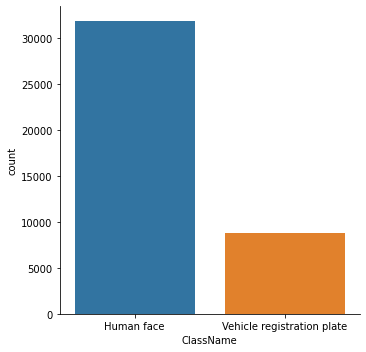

In [370]:
df_oid_train_val = pd.concat([df_oid_train, df_oid_val])
display(df_oid_train_val["ClassName"].value_counts())
display(df_oid_train_val["ClassName"].value_counts(normalize=True))
print(f"the number of images: {len(df_oid_train_val.index.unique())}")
sns.catplot(data=df_oid_train_val, x="ClassName", kind="count", order=class_order)
plt.show()

Human face                    7889
Vehicle registration plate    2843
Name: ClassName, dtype: int64

Human face                    0.735091
Vehicle registration plate    0.264909
Name: ClassName, dtype: float64

the number of images: 5282


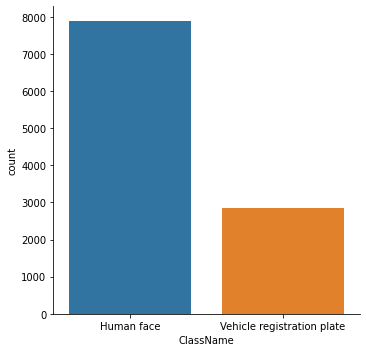

In [371]:
df_oid_test = df_oid_all[df_oid_all["set"] == "test"]
display(df_oid_test["ClassName"].value_counts())
display(df_oid_test["ClassName"].value_counts(normalize=True))
print(f"the number of images: {len(df_oid_test.index.unique())}")
sns.catplot(data=df_oid_test, x="ClassName", kind="count", order=class_order)
plt.show()

# Label to dataframe

In [200]:
def yolo_labels_to_dataframe(labels_path):
    df_all = pd.DataFrame(data=None)
    for label_path in labels_path:
        image_id = os.path.splitext(os.path.basename(label_path))[0]
        df = pd.read_csv(label_path, header=None, delimiter=' ', names=['class_index', 'x_center', 'y_center', 'width', 'height'])
        df['image_id'] = image_id
        df = df.set_index('image_id')
        df_all = pd.concat([df_all, df])
    return df_all

def display_yolo_anntation(labels_dir):
    labels_all_path = [p for p in glob.glob(labels_dir + '/**', recursive=True) if re.search('.txt', p)]
    futures = []
    with ProcessPoolExecutor(max_workers=os.cpu_count()) as executor:
        for labels_path in chunked(labels_all_path, 500):
            future = executor.submit(yolo_labels_to_dataframe, labels_path)
            futures.append(future)
    concurrent.futures.wait(futures, timeout=None)
    df_list = [future.result() for future in concurrent.futures.as_completed(futures)]
    df_all = pd.DataFrame(data=None)
    for df in df_list:
        df_all = pd.concat([df_all, df])
    return df_all

In [201]:
train_dir = "yolo/labels/train"
df_train = display_yolo_anntation(train_dir)
df_train['set'] = 'train'
print(f"the number of images: {len(df_train.index.unique())}")

the number of images: 0


In [202]:
val_dir = "yolo/labels/val"
df_val = display_yolo_anntation(val_dir)
df_val['set'] = 'val'

In [203]:
test_dir = "yolo/labels/test"
df_test = display_yolo_anntation(test_dir)
df_test['set'] = 'test'

In [11]:
class_order = ["Human face", "Vehicle registration plate"]

Human face                    77750
Vehicle registration plate    11682
Name: class_name, dtype: int64

Human face                    0.869376
Vehicle registration plate    0.130624
Name: class_name, dtype: float64

the number of images: 37310


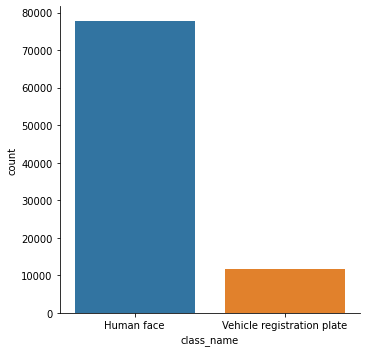

In [12]:
df_all = pd.concat([df_train, df_val, df_test])
df_all.reset_index()
df_all['class_name'] = df_all['class_index'].agg(lambda x: df_classes.loc[x, "ClassName"])
display(df_all["class_name"].value_counts())
display(df_all["class_name"].value_counts(normalize=True))
print(f"the number of images: {len(df_all.index.unique())}")
sns.catplot(data=df_all, x="class_name", kind="count", order=class_order)
plt.show()

Human face                    62584
Vehicle registration plate     8000
Name: class_name, dtype: int64

Human face                    0.88666
Vehicle registration plate    0.11334
Name: class_name, dtype: float64

the number of images: 28824


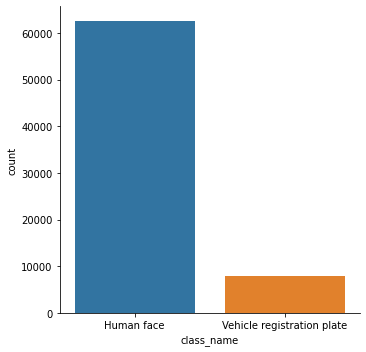

In [13]:
df_train = df_all[df_all["set"] == "train"]
display(df_train["class_name"].value_counts())
display(df_train["class_name"].value_counts(normalize=True))
print(f"the number of images: {len(df_train.index.unique())}")
sns.catplot(data=df_train, x="class_name", kind="count", order=class_order)
plt.show()

Human face                    7276
Vehicle registration plate     839
Name: class_name, dtype: int64

Human face                    0.896611
Vehicle registration plate    0.103389
Name: class_name, dtype: float64

the number of images: 3203


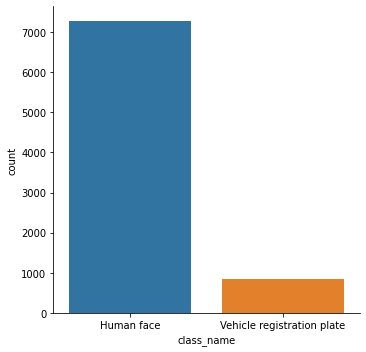

In [14]:
df_val = df_all[df_all["set"] == "val"]
display(df_val["class_name"].value_counts())
display(df_val["class_name"].value_counts(normalize=True))
print(f"the number of images: {len(df_val.index.unique())}")
sns.catplot(data=df_val, x="class_name", kind="count", order=class_order)
plt.show()

Human face                    7890
Vehicle registration plate    2843
Name: class_name, dtype: int64

Human face                    0.735116
Vehicle registration plate    0.264884
Name: class_name, dtype: float64

the number of images: 5283


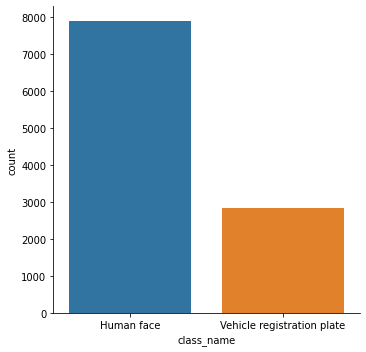

In [15]:
df_test = df_all[df_all["set"] == "test"]
display(df_test["class_name"].value_counts())
display(df_test["class_name"].value_counts(normalize=True))
print(f"the number of images: {len(df_test.index.unique())}")
sns.catplot(data = df_test, x = "class_name", kind="count", order=class_order)
plt.show()